In [1]:
train_vae = True #@param {type:"boolean"}
download_state = True #@param {type:"boolean"}
load_state = "False"  #@param ["False", "From URL", "Upload"]
load_state_url = 'https://github.com/toonnyy8/toy/raw/main/dl/vae/vae.pt' #@param {type:"string"}

if load_state == "From URL":
    !wget {load_state_url}
    
elif load_state == "Upload":
    from google.colab import files

    uploaded = files.upload()

In [2]:
!nvidia-smi

Sun Aug  1 16:12:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install einops

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch import optim

from einops import rearrange, repeat
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [6]:
class ResBlock(nn.Module):
    def __init__(self, in_dim, out_dim, k_size=3):
        super().__init__()
        self.shortcut = nn.Identity() if in_dim == out_dim else nn.Conv2d(in_dim, out_dim, 1)

        self.net = nn.Sequential(
                nn.GroupNorm(1, in_dim),
                nn.GELU(),
                nn.Conv2d(in_dim, max(in_dim, out_dim)*2, k_size, padding=k_size//2),
                nn.GroupNorm(1, max(in_dim, out_dim)*2),
                nn.GELU(),
                nn.Conv2d(max(in_dim, out_dim)*2, out_dim, k_size, padding=k_size//2),
        )
  
    def forward(self, x):
        return self.shortcut(x) + self.net(x)

In [7]:
class Encoder(nn.Module):
    def __init__(self, dims, latent_dim):
        super().__init__()
        creat_nn = lambda in_dim, dim: nn.Sequential(
                ResBlock(in_dim, dim, 3),
                nn.AvgPool2d(2,2),
            )

        self.net = nn.Sequential(
            *[creat_nn(dims[i], dim) for i, dim in enumerate(dims[1:])],
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(dims[-1], latent_dim*2, 1,),
            nn.Flatten(),
        )
  
    def forward(self, x):
        mu, logvar = torch.chunk(self.net(x), 2, 1)
        return self.reparameterize(mu, logvar), mu, logvar

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z

In [8]:
class Decoder(nn.Module):
    def __init__(self, cond_num, latent_dim, pos_dim, dims, out_dim, scale):
        super().__init__()
        self.B = nn.Parameter(torch.randn(2, pos_dim, device=device)*scale, requires_grad=False)
        self.cond_vecs = nn.Parameter(torch.randn(cond_num, 2, pos_dim, device=device)*scale, requires_grad=False)# torch.eye(cond_num, device=device)

        self.net = nn.Sequential(
            nn.Conv2d(pos_dim*4+latent_dim, dims[0], 1),
            *[ResBlock(dims[i], dim, 1) for i, dim in enumerate(dims[1:])],
            nn.GroupNorm(1, dims[-1]),
            nn.GELU(),
            nn.Conv2d(dims[-1], out_dim, 1),
            nn.Sigmoid(),
        )
  
    def forward(self, conds, latent_vecs, H, W):
        coords_x = np.linspace(0, 1, W,)
        coords_y = np.linspace(0, 1, H,)
        coords = np.stack(np.meshgrid(coords_x, coords_y), 0) # (C, H, W)
        coords = torch.tensor(coords, dtype=torch.float32, device=device)

        pos_emb = repeat(torch.einsum('chw,cd->dhw', coords, self.B), 'd h w -> b d h w', b=len(conds))
        cond_pos_emb = torch.einsum('chw,bcd->bdhw', coords, self.cond_vecs[conds])
        u = 2*math.pi*torch.cat([pos_emb, cond_pos_emb], 1)

        v = repeat(latent_vecs, 'b d -> b d h w', h=H, w=W)
        z = torch.cat([torch.cos(u), torch.sin(u), v], 1)

        out = self.net(z)
        return out

In [9]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

In [10]:
epochs = 50
batch_size = 128
latent_dim = 64
cond_num = 10

In [11]:
enc_net = Encoder([3, 32, 64, 128, 128, 128], latent_dim).to(device)
dec_net = Decoder(cond_num, latent_dim, 256, [256, 256, 256, 256], 3, 4).to(device)
opt = optim.Adamax(params=[*enc_net.parameters(), *dec_net.parameters()])

In [12]:
if not (load_state == 'False'):
    checkpoint = torch.load("./vae.pt", map_location=device)

    enc_net.load_state_dict(checkpoint['enc_net'])
    dec_net.load_state_dict(checkpoint['dec_net'])
    opt.load_state_dict(checkpoint['opt'])

In [13]:
if train_vae:
    transform = transforms.Compose([
        transforms.ToTensor(),            
    ])
    trainSet = CIFAR10(root='CIFAR10', download=True, train=True, transform=transform)
    trainLoader = DataLoader(trainSet, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 391/391 [03:18<00:00,  1.97it/s]


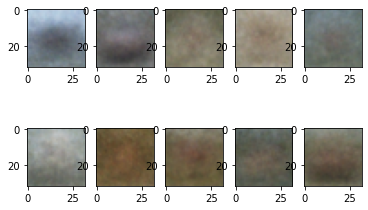

100%|██████████| 391/391 [03:20<00:00,  1.95it/s]


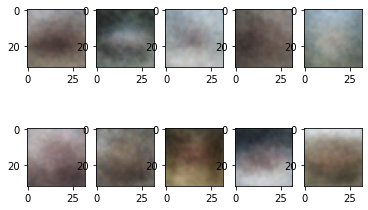

100%|██████████| 391/391 [03:20<00:00,  1.95it/s]


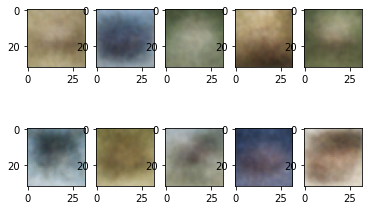

100%|██████████| 391/391 [03:20<00:00,  1.95it/s]


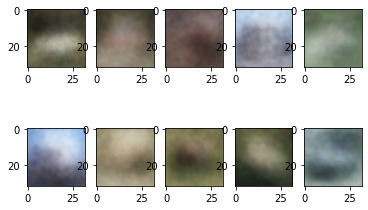

100%|██████████| 391/391 [03:20<00:00,  1.95it/s]


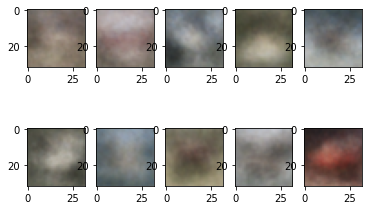

100%|██████████| 391/391 [03:20<00:00,  1.95it/s]


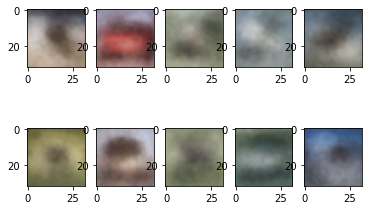

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


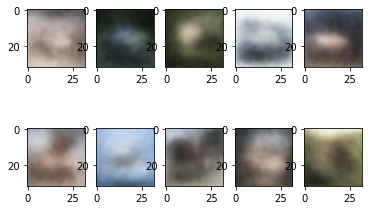

100%|██████████| 391/391 [03:20<00:00,  1.95it/s]


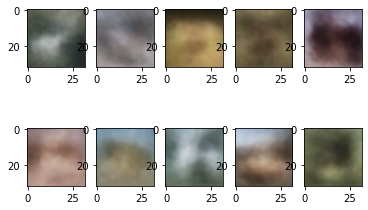

100%|██████████| 391/391 [03:19<00:00,  1.96it/s]


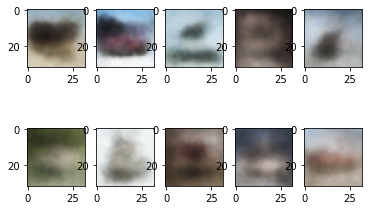

100%|██████████| 391/391 [03:19<00:00,  1.96it/s]


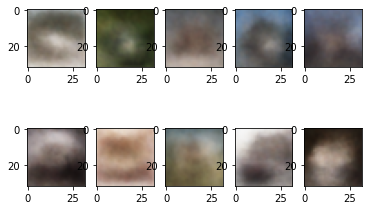

100%|██████████| 391/391 [03:19<00:00,  1.96it/s]


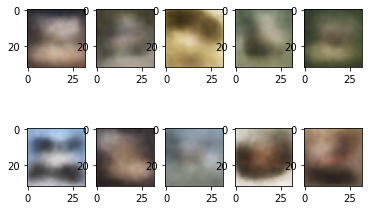

100%|██████████| 391/391 [03:19<00:00,  1.96it/s]


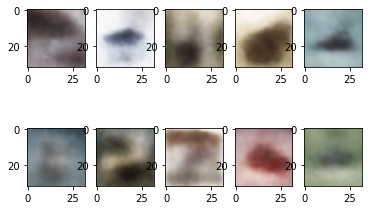

100%|██████████| 391/391 [03:19<00:00,  1.96it/s]


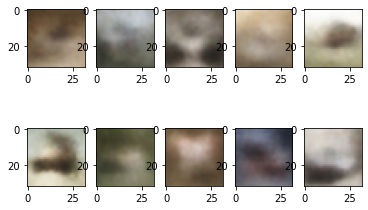

100%|██████████| 391/391 [03:19<00:00,  1.96it/s]


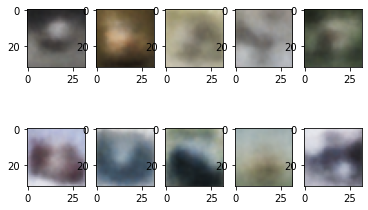

100%|██████████| 391/391 [03:19<00:00,  1.96it/s]


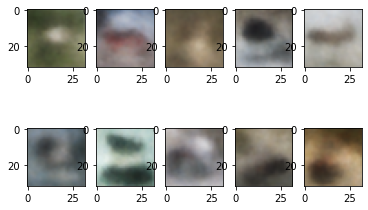

100%|██████████| 391/391 [03:19<00:00,  1.96it/s]


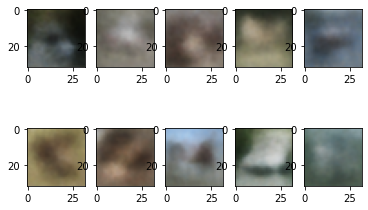

100%|██████████| 391/391 [03:19<00:00,  1.96it/s]


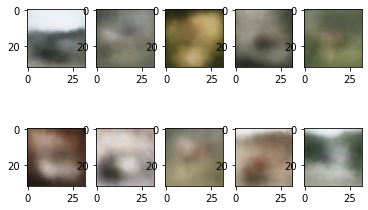

100%|██████████| 391/391 [03:19<00:00,  1.96it/s]


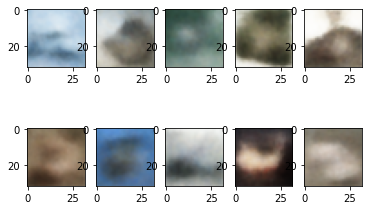

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


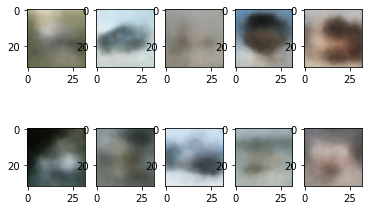

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


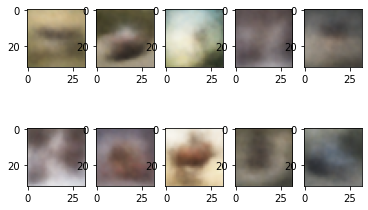

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


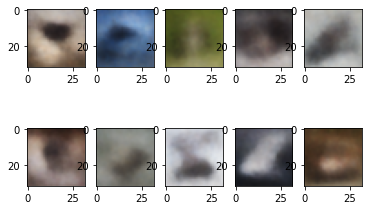

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


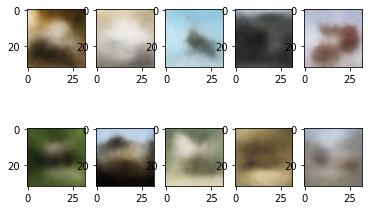

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


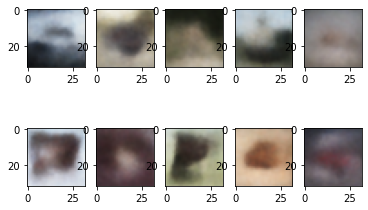

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


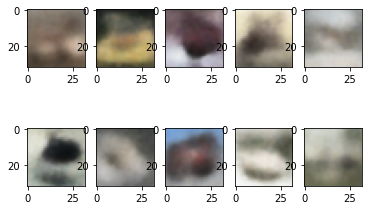

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


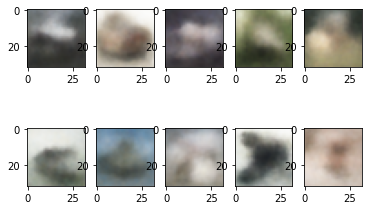

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


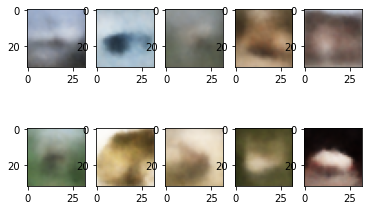

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


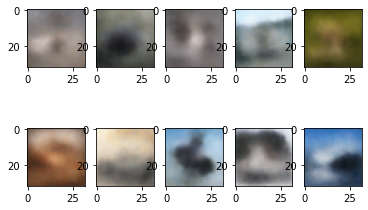

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


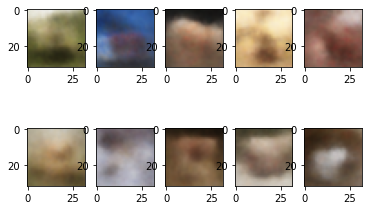

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


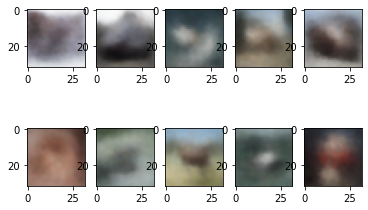

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


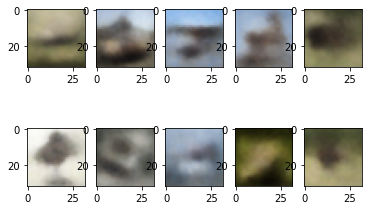

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


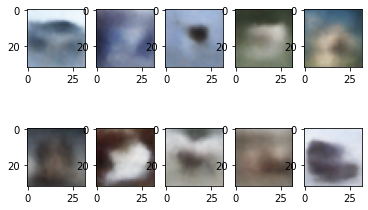

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


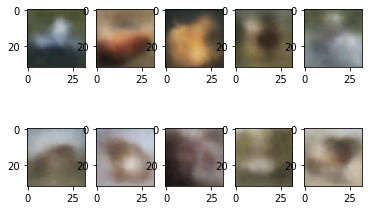

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


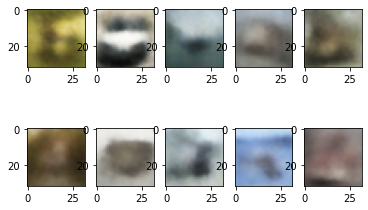

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


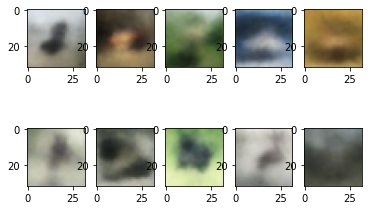

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


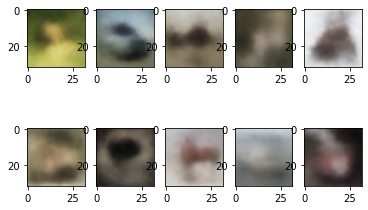

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


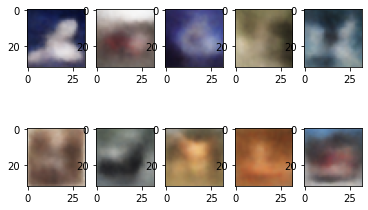

100%|██████████| 391/391 [03:20<00:00,  1.95it/s]


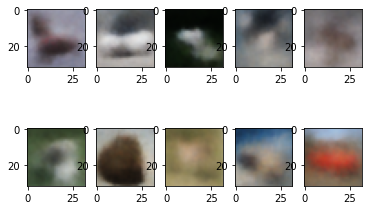

100%|██████████| 391/391 [03:20<00:00,  1.95it/s]


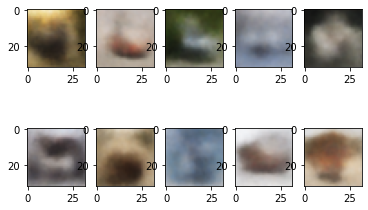

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


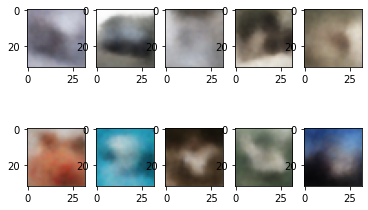

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


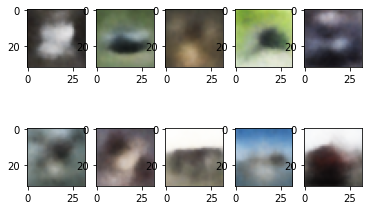

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


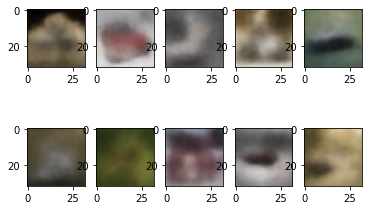

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


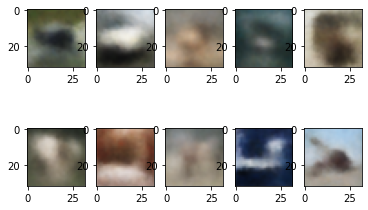

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


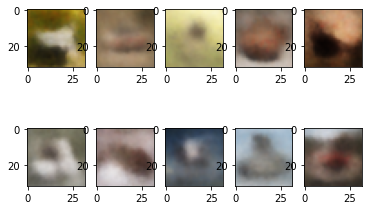

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


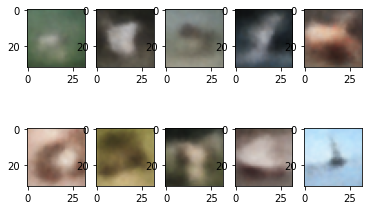

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


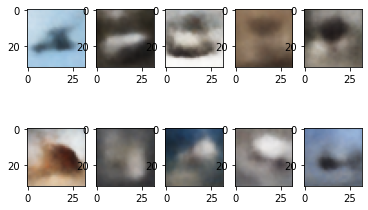

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


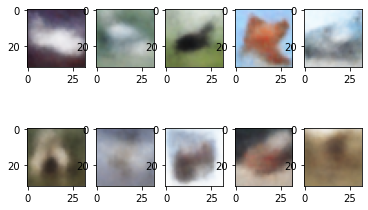

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


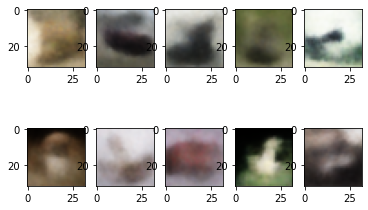

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


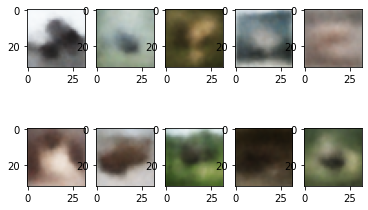

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


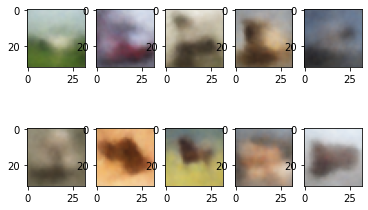

100%|██████████| 391/391 [03:21<00:00,  1.94it/s]


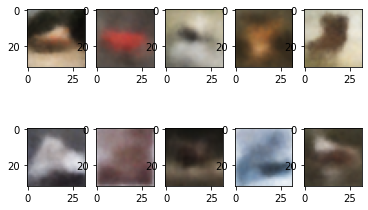

In [14]:
if train_vae:
    for epoch in range(epochs):
        for (imgs,labels) in tqdm(trainLoader):
            gc.collect()
            torch.cuda.empty_cache()

            _bz = labels.shape[0]
            imgs = imgs.to(device)
            labels = labels.to(device)

            latent_vecs, mu, logvar = enc_net(imgs)
            recon_x = dec_net(labels, latent_vecs, H=32, W=32)

            loss = loss_fn(recon_x, imgs, mu, logvar)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        with torch.no_grad():
            labels = torch.arange(0, 10, device=device)
            latent_vecs = torch.randn(10, latent_dim, device=device)

            dec_out = dec_net(labels, latent_vecs, H=32, W=32)

            fig , ax = plt.subplots()
            for i in range(1, 11):
                plt.subplot(2, 5, i)
                plt.imshow(rearrange(dec_out[i-1], 'c h w -> h w c').cpu().data)
            plt.show()


In [15]:
if download_state:
    torch.save({
        "enc_net":enc_net.state_dict(),
        "dec_net":dec_net.state_dict(),
        "opt":opt.state_dict(),
    }, './vae.pt')

    from google.colab import files

    files.download('./vae.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
#@title 生成圖片
%matplotlib inline
from ipywidgets import interactive, widgets

gen_class = 0  #@param {type:"slider", min:0, max:9, step:1}
gen_size = 28  #@param {type:"slider", min:16, max:128, step:1}

dec_net.eval()

def f(**kwargs):
    latent_vec = torch.tensor([[kwargs['dim {}'.format(i)] for i in range(latent_dim)]], device=device)
    with torch.no_grad():
        g_out = dec_net(torch.tensor([int(gen_class)], device=device), latent_vec, H=int(gen_size), W=int(gen_size))
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(rearrange(g_out[0], 'c h w -> h w c').cpu().data)
    plt.show()

    return
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)
names = [['dim {}'.format(i), [0., -5., 5]] for i in range(latent_dim)]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

NameError: ignored